## Example for CESM2

**NOTE**: Compared to the CESM1 demo, here "Q" (QBOT), "U" (UBOT) and "V" (VBOT) are not included. When the bottom "lev" of "Q", "U", and "V" are merged, there is an issue.   

Reference:     
- GitHub: https://github.com/NCAR/cesm2-le-aws    
- Data/Variables Information: https://ncar.github.io/cesm2-le-aws/model_documentation.html#data-catalog       
- Reproduce CESM-LENS: https://github.com/NCAR/cesm2-le-aws/blob/main/notebooks/kay_et_al_lens2.ipynb   

**Step 0: load necessary packages and define parameters (no need to change)**

In [1]:
%%time
# Display output of plots directly in Notebook
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import json
from flaml import AutoML
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")
import util

with open("./config_cesm2.json",'r') as load_f:
#     param = json.loads(json.load(load_f))
    param = json.load(load_f)
    
    model = param["model"] # cesm2
    urban_type = param["urban_type"] # md
    city_loc = param["city_loc"] # {"lat": 40.0150, "lon": -105.2705}
    l_component = param["l_component"]
    a_component = param["a_component"]
    experiment = param["experiment"]
    frequency = param["frequency"]
    cam_ls = param["cam_ls"]
    clm_ls = param["clm_ls"]
    forcing_variant = param["forcing_variant"]
    time = slice(param["time_start"],param["time_end"])
    member_id = param["member_id"]
    estimator_list = param["estimator_list"]
    time_budget = param["time_budget"]
    features = param["features"]
    label = param["label"]
    clm_var_mask = param["label"][0]
    
# get a dataset
ds = util.get_data(model, city_loc, experiment, frequency, member_id, time, cam_ls, clm_ls,
                   forcing_variant=forcing_variant, urban_type=urban_type)

# create a dataframe
ds['time'] = ds.indexes['time'].to_datetimeindex()
df = ds.to_dataframe().reset_index().dropna()

if "PRSN" in features:
    df["PRSN"] = df["PRECSC"] + df["PRECSL"]
if "PRECT" in features:
    df["PRECT"] = df["PRECC"] + df["PRECL"]
    
# setup for automl
automl = AutoML()
automl_settings = {
    "time_budget": time_budget,  # in seconds
    "metric": 'r2',
    "task": 'regression',
    "estimator_list":estimator_list,
}

/glade/work/zhonghua/miniconda3/envs/aws_urban/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency.forcing_variant'


different lat between CAM and CLM subgrid info, adjust subgrid info's lat
CPU times: user 56.9 s, sys: 34 s, total: 1min 30s
Wall time: 58.4 s


### Step 1: data analysis

**xarray.Dataset**

In [2]:
ds

<xarray.Dataset>
Dimensions:    (member_id: 1, time: 7299)
Coordinates:
    lat        float64 40.05
    lon        float64 255.0
  * member_id  (member_id) <U12 'r1i1231p1f1'
  * time       (time) datetime64[ns] 2081-01-02T12:00:00 ... 2100-12-31T12:00:00
Data variables:
    TREFHT     (member_id, time) float32 273.2 273.4 275.7 ... 276.7 277.0 277.4
    TREFHTMX   (member_id, time) float32 276.2 278.8 282.8 ... 283.9 284.8 283.7
    FLNS       (member_id, time) float32 93.1 82.03 82.87 ... 88.49 87.6 67.41
    FSNS       (member_id, time) float32 90.73 84.27 91.37 ... 91.55 91.45 77.9
    PRECSC     (member_id, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PRECSL     (member_id, time) float32 4.184e-10 4.287e-10 ... 9.825e-21
    PRECC      (member_id, time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    PRECL      (member_id, time) float32 4.251e-10 4.42e-10 ... 1.181e-08
    TREFMXAV   (member_id, time) float64 277.0 279.3 284.4 ... 284.3 285.7 284.4
Attributes:
    host:                    mom1
    topography_file:         /mnt/lustre/share/CESM/cesm_input/atm/cam/topo/f...
    logname:                 sunseon
    time_period_freq:        day_1
    intake_esm_varname:      FLNS\nFSNS\nPRECC\nPRECL\nPRECSC\nPRECSL\nTREFHT...
    Conventions:             CF-1.0
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source:                  CAM
    intake_esm_dataset_key:  atm.ssp370.daily.cmip6

**pandas dataframe**

In [3]:
df.head()

,member_id,time,TREFHT,TREFHTMX,FLNS,FSNS,PRECSC,PRECSL,PRECC,PRECL,lat,lon,TREFMXAV,PRSN,PRECT
0,r1i1231p1f1,2081-01-02 12:00:00,273.180023,276.192291,93.097984,90.734787,0.0,4.183626e-10,0.0,4.251142e-10,40.052356,255.0,276.999237,4.183626e-10,4.251142e-10
1,r1i1231p1f1,2081-01-03 12:00:00,273.396667,278.823547,82.032143,84.271416,0.0,4.287326e-10,0.0,4.419851e-10,40.052356,255.0,279.335205,4.287326e-10,4.419851e-10
2,r1i1231p1f1,2081-01-04 12:00:00,275.675842,282.826111,82.870590,91.365944,0.0,1.492283e-15,0.0,7.843200e-14,40.052356,255.0,284.418121,1.492283e-15,7.843200e-14
3,r1i1231p1f1,2081-01-05 12:00:00,275.782043,282.312042,90.888451,92.246887,0.0,3.730888e-17,0.0,3.108414e-15,40.052356,255.0,283.729095,3.730888e-17,3.108414e-15
4,r1i1231p1f1,2081-01-06 12:00:00,272.146301,275.967560,56.035732,55.395706,0.0,5.766720e-11,0.0,9.267757e-11,40.052356,255.0,278.923859,5.766720e-11,9.267757e-11


**data visualization**

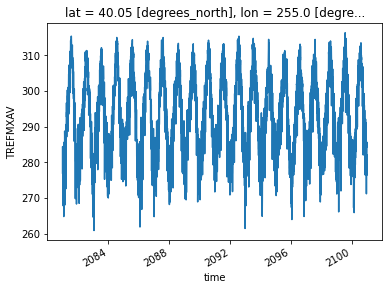

In [4]:
ds["TREFMXAV"].plot()

### Step 2: automated machine learning

**train a model (emulator)**

In [5]:
%%time
# assume that we want to split the data into training data and testing data
# let's use first 95% for training, and the remaining for testing 
idx = df.shape[0]
train = df.iloc[:int(0.95*idx),:]
test = df.iloc[int(0.95*idx):,:]
(X_train, y_train) = (train[features], train[label].values)
(X_test, y_test) = (test[features], test[label].values)

# train the model
automl.fit(X_train=X_train, y_train=y_train,
           **automl_settings, verbose=-1)
print(automl.model.estimator)

LGBMRegressor(colsample_bytree=0.7463308378914483,
              learning_rate=0.1530612501227463, max_bin=1023,
              min_child_samples=2, n_estimators=60, num_leaves=49,
              reg_alpha=0.0009765625, reg_lambda=0.012698515198279536,
              verbose=-1)
CPU times: user 3min 20s, sys: 2.53 s, total: 3min 22s
Wall time: 15.2 s


**apply and test the machine learning model**      
use `automl.predict(X)` to apply the model

In [6]:
# training data
print("model performance using training data:")
y_pred = automl.predict(X_train)
print("root mean square error:", 
      mean_squared_error(y_true=y_train, y_pred=y_pred, squared=False))
print("r2:", r2_score(y_true=y_train, y_pred=y_pred),"\n")
import pandas as pd
d_train = {"time":train["time"],"y_train":y_train.reshape(-1),"y_pred":y_pred.reshape(-1)}
df_train = pd.DataFrame(d_train).set_index("time")

# testing data
print("model performance using testing data:")
y_pred = automl.predict(X_test)
print("root mean square error:", 
      mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False))
print("r2:", r2_score(y_true=y_test, y_pred=y_pred))
d_test = {"time":test["time"],"y_test":y_test.reshape(-1),"y_pred":y_pred.reshape(-1)}
df_test = pd.DataFrame(d_test).set_index("time")

model performance using training data:
root mean square error: 1.0953179201882188
r2: 0.9908044117105271 

model performance using testing data:
root mean square error: 1.6714483065300212
r2: 0.9799441548983633


**visualization**

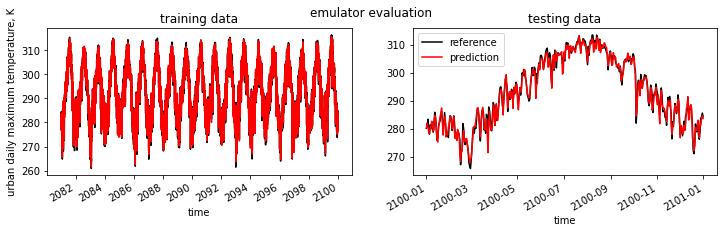

In [7]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,3))
fig.suptitle('emulator evaluation')
df_train["y_train"].plot(label="reference",c="k",ax=ax1)
df_train["y_pred"].plot(label="prediction",c="r",ax=ax1)
ax1.set_title("training data")
ax1.set_ylabel("urban daily maximum temperature, K")

df_test["y_test"].plot(label="reference",c="k",ax=ax2)
df_test["y_pred"].plot(label="prediction",c="r",ax=ax2)
ax2.set_title("testing data")
plt.legend()
plt.show()